In [1]:
import os
import glob
import numpy as np

from PIL import Image, ImageDraw
import scipy.ndimage.morphology as morph

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from args import *

In [2]:
import json
with open('/storage/ProtopopovI/_data_/COCO/2014/annotations/person_keypoints_train2014.json') as data_file:    
    data_json = json.load(data_file)

In [3]:
file_path = "/storage/ProtopopovI/_data_/COCO/2014/train2014/"
file_names = sorted(os.listdir("/storage/ProtopopovI/_data_/COCO/2014/train2014/"))
images_info = data_json['images']
images_anno = data_json['annotations']
#images_anno[160264]['segmentation']

In [4]:
def file_info(idx):
    file_name = file_names[idx]
    ##### image info: img_id, img_height, img_width
    for i in range(len(images_info)):
        if file_name == images_info[i]['file_name']:
            img_id = images_info[i]['id']
            img_height = images_info[i]['height']
            img_width = images_info[i]['width']
    img = Image.open(file_path + file_name)
    img_info = {
        'img_name' : file_name,
        'img_id' : img_id,
        'img_height' : img_height,
        'img_width' : img_width,
        'img' : img
    }
    ##### {boxes and masks}:::
    bboxs = []
    x_centers = []
    y_centers = []
    widths = []
    heights = []
    masks = []
    widths_scales = []
    heights_scales = []
    stats = []
    crop_masks = []
    for i in range(len(images_anno)):
        if img_id == images_anno[i]['image_id']:
            box = images_anno[i]['bbox'] # box --> [x,y,width,height]
            bboxs.append(box)
            ##### {reshape info}:
            x_centers.append(box[0]+box[2]/2)
            y_centers.append(box[1]+box[3]/2)
            widths.append(box[2])
            heights.append(box[3])
            widths_scales.append(box[2]/img_info['img_width'])
            heights_scales.append(box[3]/img_info['img_height'])
            
            print((box[2]/img_info['img_width']*box[3]/img_info['img_height']))
            if (box[2]/img_info['img_width']*box[3]/img_info['img_height']) > (2/8):
                status = 'large'
            else:
                if (box[2]/img_info['img_width']*box[3]/img_info['img_height']) > (1/80):
                    status = 'medium'
                else:
                    status = 'small'
            stats.append(status)
                # {reshape info} #####
            ##### {build mask}:
            mask = Image.new('L', (img_width, img_height))
            idraw = ImageDraw.Draw(mask)
            try:
                idraw.polygon(images_anno[i]['segmentation'][0], fill='white')
            except KeyError:
                pass
                # {build mask} #####
            masks.append(mask)
            ##### {crop mask}: left=box[0], top=box[1], right=box[0]+box[2], bottom=box[1]+box[3]
            if box[2] < img_info['img_width']:
                crop_mask = mask.crop((box[0], box[1], box[0]+box[2], box[1]+box[3]))
                crop_masks.append(crop_mask)
        # {boxes and masks} #####
    num_objects = len(bboxs)
    
    labels = {
        'num_objects' : num_objects,
        'bboxs' : bboxs,
        'x_centers' : x_centers,
        'y_centers' : y_centers,
        'widths' : widths,
        'heights' : heights,
        'masks' : masks,
        'crop_masks' : crop_masks,
        'widths_scales' : widths_scales,
        'heights_scales' : heights_scales,
        'stats' : stats
    }
    return img_info, labels

In [19]:
img_info, labels = file_info(110)
img_info

0.8703675391539812
0.018046853044496484
0.03687716298302107
0.009843496048009368


{'img_name': 'COCO_train2014_000000010646.jpg',
 'img_id': 10646,
 'img_height': 640,
 'img_width': 427,
 'img': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=427x640 at 0x7FFF74FD9D90>}

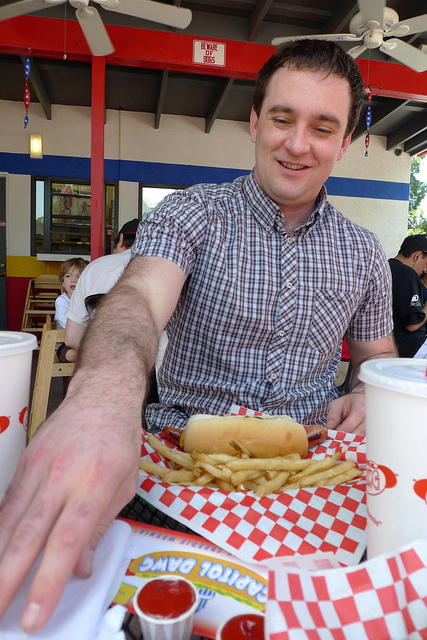

In [20]:
Image.open(file_path + img_info['img_name'])

In [21]:
labels

{'num_objects': 4,
 'bboxs': [[0, 35.87, 397.49, 598.39],
  [386.92, 235.2, 40.08, 123.05],
  [62.28, 218.52, 76.83, 131.17],
  [55.96, 256.68, 34.94, 76.99]],
 'x_centers': [198.745, 406.96000000000004, 100.695, 73.43],
 'y_centers': [335.065, 296.72499999999997, 284.105, 295.175],
 'widths': [397.49, 40.08, 76.83, 34.94],
 'heights': [598.39, 123.05, 131.17, 76.99],
 'masks': [<PIL.Image.Image image mode=L size=427x640 at 0x7FFF74FD9C10>,
  <PIL.Image.Image image mode=L size=427x640 at 0x7FFF74FCAED0>,
  <PIL.Image.Image image mode=L size=427x640 at 0x7FFF74FD9CD0>,
  <PIL.Image.Image image mode=L size=427x640 at 0x7FFF74FE2290>],
 'crop_masks': [<PIL.Image.Image image mode=L size=397x598 at 0x7FFF74FD9E90>,
  <PIL.Image.Image image mode=L size=40x123 at 0x7FFF74FD9950>,
  <PIL.Image.Image image mode=L size=77x131 at 0x7FFF74FD9D50>,
  <PIL.Image.Image image mode=L size=35x77 at 0x7FFF74FE2410>],
 'widths_scales': [0.9308899297423888,
  0.09386416861826698,
  0.17992974238875878,
  0

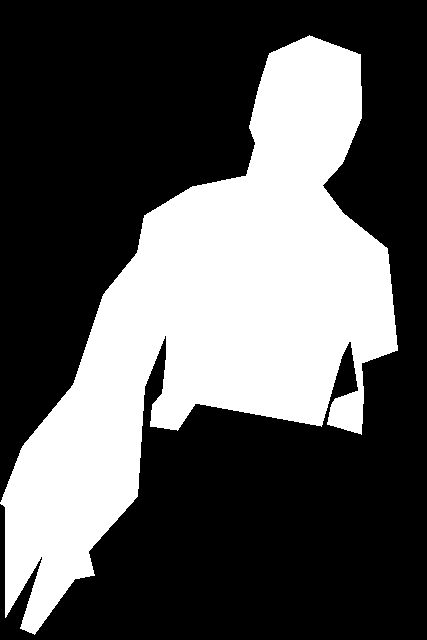

In [23]:
(labels['masks'][0])